<a href="https://colab.research.google.com/github/kosukemtr/microwave/blob/main/microwave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マイクロ波フィルタ素子値計算用ノートブック

## LTSpice のデータプロット

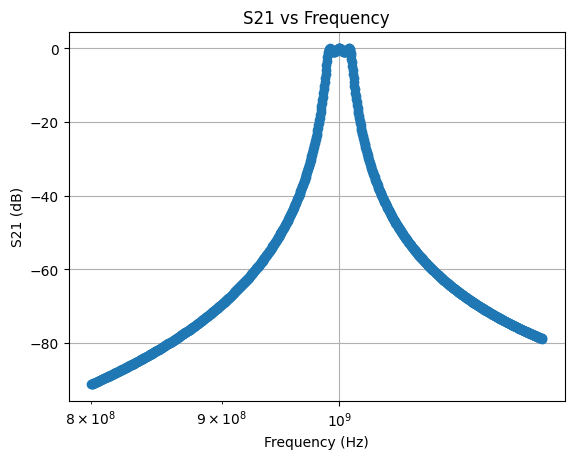

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the file and extract the data
with open('/content/Draft1.txt', 'r', encoding='ISO-8859-1') as f:
    lines = f.readlines()

frequencies = []
dB_values = []

for line in lines[1:]:
    parts = line.strip().split('\t')  # Assuming the data is tab-separated
    frequency = float(parts[0])
    s21 = parts[1].split(',')[0]  # Split by comma to get the dB part
    dB = float(s21[1:-2])  # Remove the "dB" part and convert to float
    frequencies.append(frequency)
    dB_values.append(dB)

# Convert lists to numpy arrays for better performance with matplotlib
frequencies = np.array(frequencies)
dB_values = np.array(dB_values)

# Plotting
plt.plot(frequencies, dB_values, marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('S21 (dB)')
plt.title('S21 vs Frequency')
plt.xscale("log")
plt.grid(True)
plt.show()


## 4.4.1.2 低域通過フィルタへの変換

以下の式によって必要な L, C の値を決定する。

In [ ]:
import numpy as np

g1 = 1.4909
g2 = 1.1180
g3 = 1.4909
R0 = 50
omegac = 1e9 * 2 * np.pi

In [ ]:
L1 = g1 * R0 / omegac
C1 = g2 / R0 / omegac
L2 = g3 * R0 / omegac
L1, C1, L2

(1.1864205232785335e-08, 3.55870452753478e-12, 1.1864205232785335e-08)

## 4.4.1.3 帯域通過フィルタ

In [ ]:
omega0 = 1e9 * 2 * np.pi
BW = 50e6 * 2 * np.pi
omega2 = omega0 + BW/2
omega1 = omega0 - BW/2
Delta = BW/omega0
L1 = g1 * R0 / omega0 / Delta
C1 = Delta / R0 / omega0 / g1
L2 = R0 * Delta / omega0 / g2
C2 = g2 / R0 / omega0 / Delta
L3 = g3 * R0 / omega0 / Delta
C3 = Delta / R0 / omega0 / g3
# spice directive
print(f".param l1={L1} c1={C1} l2={L2} c2={C2} l3={L3} c3={C3}")

.param l1=1.4908999999999998e-06 c1=1.6989936220125057e-14 l2=5.6641985488784526e-11 c2=4.472e-10 l3=1.4908999999999998e-06 c3=1.6989936220125057e-14


## 4.4.1.4 Kインバータによる直並列変換

In [ ]:
M = 1/omega0
print(f".param M={M}")
L1 = g1 * R0 / omega0 / Delta
C1 = Delta / R0 / omega0 / g1
C2 = R0 * Delta / omega0 / g2
L2 = g2 / R0 / omega0 / Delta
L3 = g3 * R0 / omega0 / Delta
C3 = Delta / R0 / omega0 / g3
print(f".param l1={L1} c1={C1} l2={L2} c2={C2} l3={L3} c3={C3}")

.param M=1.5915494309189535e-10
.param l1=1.4908999999999998e-06 c1=1.6989936220125057e-14 l2=4.472e-10 c2=5.6641985488784526e-11 l3=1.4908999999999998e-06 c3=1.6989936220125057e-14


## 4.4.1.5 トランスの結合係数の計算

In [ ]:
k1 = M/np.sqrt(L1*L2/2)
k2 = M/np.sqrt(L3*L2/2)
print(f".param k1={k1} k2={k2}")

.param k1=0.019942454348982792 k2=0.019942454348982792


## 4.4.2.1 特性インピーダンスが 50 オームとなる導体幅 W の計算

ChatGPT により生成。参考 https://chat.openai.com/share/0d72d285-18e6-45de-8563-f920d0b825bd

In [ ]:
import math

def calculate_W(Z_0, epsilon_r, d):
    """
    Calculate the width W of a microstrip line to achieve a characteristic impedance Z_0.

    Parameters:
        Z_0 (float): Characteristic impedance.
        epsilon_r (float): Relative permittivity of the substrate.
        d (float): Thickness of the substrate.

    Returns:
        float: Width of the microstrip line W.
    """
    # Calculate A and B as per the given formulas
    A = (Z_0 / 60) * math.sqrt((epsilon_r + 1) / 2) + ((epsilon_r - 1) / (epsilon_r + 1)) * (0.23 + (0.11 / epsilon_r))
    B = (377 * math.pi) / (2 * Z_0 * math.sqrt(epsilon_r))

    # Determine the regime and calculate W/d accordingly
    try:
        W_d_candidate_1 = (8 * math.exp(A)) / (math.exp(2 * A) - 2)  # First equation for W/d
        W_d_candidate_2 = (2 / math.pi) * (B - 1 - math.log(2 * B - 1) +
                           ((epsilon_r - 1) / (2 * epsilon_r)) *
                           (math.log(B - 1) + 0.39 - (0.61 / epsilon_r)))  # Second equation for W/d

        # Choose the appropriate W/d value based on the condition W/d < 2 or W/d > 2
        if W_d_candidate_1 < 2:
            W_d = W_d_candidate_1
        else:
            W_d = W_d_candidate_2

        # Finally calculate and return W using W = d * W/d
        W = d * W_d

        return W

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Example usage:
# Z_0 = 50 Ohm, epsilon_r = 2.17, d = 1 mm
Z_0 = 50
epsilon_r = 2.17
d = 1e-3

W = calculate_W(Z_0, epsilon_r, d)
print(f"The width of the microstrip line W = {W} m")

The width of the microstrip line W = 0.0031081054496004423 m


## 4.4.2.2 共振器長の設計

In [ ]:
def calculate_lambda(f, epsilon_r, W, d):
    # Speed of light in m/s
    c = 3e8

    # Calculate effective permittivity epsilon_e
    epsilon_e = (epsilon_r + 1)/2 + ((epsilon_r - 1)/2) * (1/math.sqrt(1 + 12*d/W))

    # Calculate angular frequency omega
    omega = f

    # Calculate and return lambda
    lambda_ = c / (omega * math.sqrt(epsilon_e))
    return lambda_
Z_0 = 50
epsilon_r = 2.17
d = 1e-3
# Example usage:
# f = 1 GHz, d = 1 mm
f = 1e9
d = 1e-3

lambda_ = calculate_lambda(f, epsilon_r, W, d)
print(f"The wavelength in the microstrip line \u03BB = {lambda_} m")
print(f"Resonator length: {lambda_/2*1e6} um")

The wavelength in the microstrip line λ = 0.2205442666223904 m
Resonator length: 110272.1333111952 um


次に上のコードで得られた共振器長の周りで、AWR 上で長さを変えながらシミュレーションを行い、共振周波数と Q をプロットする。AWRのグラフデータをテキストとしてエクスポートして、google colab のセッションストレージにアップロードすると読み込めるようになる。pandas で読み込み matplotlib でプロットする。ChatGPT にコードを生成してもらう。https://chat.openai.com/share/5a560c1f-dccb-4de5-aa0a-d9c7544bbf53

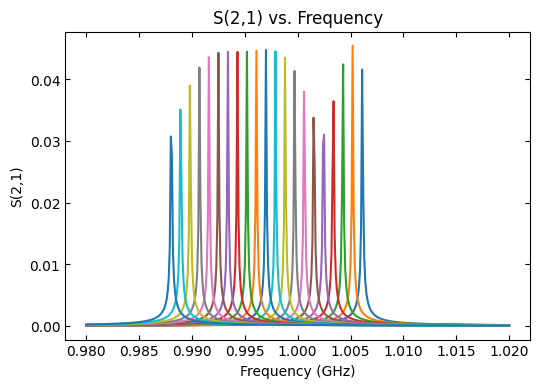

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from a.txt in Colab
data = pd.read_csv('/content/l.txt', sep='\t')
# Display the first few rows of the DataFrame
# Assuming 'Frequency (GHz)' is the name of the frequency column
plt.figure(figsize=(6, 4))  # Optional: Set the figure size

# Plot each column against the frequency
for column in data.columns[1:]:  # Skipping the frequency column for plotting
    plt.plot(data['Frequency (GHz)'], data[column], label=column)

plt.xlabel('Frequency (GHz)')
plt.ylabel('S(2,1)')
plt.title('S(2,1) vs. Frequency')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))  # To avoid overlap of legend with the plot
plt.tick_params(axis='both', which='both', direction='in',  top=True, right=True)
plt.show()

共振周波数は S21 が max になる点としてとり、また Q は最大値から $1/\sqrt{2}$ になる点から計算すればよい。ChatGPT にそのように指示を出せばよい。

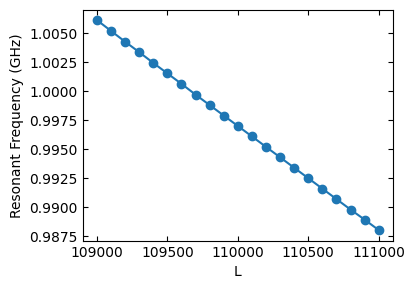

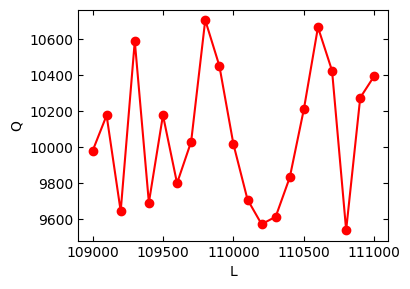

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Sample Data Loading
data = pd.read_csv('/content/l.txt', sep='\t')

# Initialize lists to store the resonant frequencies and Q values for each L
res_freqs = []
Q_values = []

# Assuming the L values are embedded in the column names
# Extracting L values from the column names and converting them to integers
L_values = [float(re.search(r'\d+(\.\d+)?', col.split('=')[1]).group()) for col in data.columns[1:]]


# Loop through each column (ignoring the frequency column)
for column in data.columns[1:]:
    # 1. Find the resonant frequency f0: frequency with maximum S21
    f0_index = data[column].idxmax()
    f0 = data['Frequency (GHz)'].iloc[f0_index]
    res_freqs.append(f0)

    # Find points around f1 and f2 for interpolation
    target_S21 = data[column].iloc[f0_index] / np.sqrt(2)
    f1_index = (data[column].iloc[:f0_index] - target_S21).abs().idxmin()
    f2_index = (data[column].iloc[f0_index:] - target_S21).abs().idxmin()
    f1_lower, f1_upper = data['Frequency (GHz)'].iloc[f1_index-1], data['Frequency (GHz)'].iloc[f1_index+1]
    S21_f1_lower, S21_f1_upper = data[column].iloc[f1_index-1], data[column].iloc[f1_index+1]

    f2_lower, f2_upper = data['Frequency (GHz)'].iloc[f2_index-1], data['Frequency (GHz)'].iloc[f2_index+1]
    S21_f2_lower, S21_f2_upper = data[column].iloc[f2_index-1], data[column].iloc[f2_index+1]

    # Linear interpolation to find more precise f1 and f2
    m_f1 = (S21_f1_upper - S21_f1_lower) / (f1_upper - f1_lower)
    c_f1 = S21_f1_lower - m_f1 * f1_lower
    f1_precise = (target_S21 - c_f1) / m_f1

    m_f2 = (S21_f2_upper - S21_f2_lower) / (f2_upper - f2_lower)
    c_f2 = S21_f2_lower - m_f2 * f2_lower
    f2_precise = (target_S21 - c_f2) / m_f2

    # Calculate Q: f0/(f2 - f1)
    Q = f0 / (f2_precise - f1_precise)
    Q_values.append(Q)

# Plot Resonant Frequency vs. L
plt.figure(figsize=(4, 3))
plt.plot(L_values, res_freqs, marker='o', linestyle='-', label='Resonant Frequency')
plt.xlabel('L')
plt.ylabel('Resonant Frequency (GHz)')
# plt.title('Resonant Frequency vs. L')
plt.tick_params(axis='both', which='both', direction='in',  top=True, right=True)
plt.show()

# Plot Q vs. L
plt.figure(figsize=(4, 3))
plt.plot(L_values, Q_values, marker='o', linestyle='-', label='Q Factor', color='r')
plt.xlabel('L')
plt.ylabel('Q')
# plt.title('Q vs. L')
plt.tick_params(axis='both', which='both', direction='in',  top=True, right=True)
plt.show()


線形補間により精度のよい L を得る。

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Load your data as before] ...

# Extract L values using regex
L_values = [float(re.search(r'\d+(\.\d+)?', col.split('=')[1]).group()) for col in data.columns[1:]]

res_freqs = []

# Find resonant frequencies for each L
for column in data.columns[1:]:
    # Find the index of the resonant frequency (frequency with max S21)
    res_freq_idx = data[column].idxmax()
    # Append resonant frequency to the list
    res_freqs.append(data['Frequency (GHz)'].iloc[res_freq_idx])

# Find L where resonant frequency crosses 1 GHz
L_target = None
for i, (L, f_res) in enumerate(zip(L_values, res_freqs)):
    # If f_res is 1 GHz, we already have our answer
    if f_res == 1.0:
        L_target = L
        break

    # If we've gone past 1 GHz and the previous resonant frequency was below 1 GHz
    elif f_res > 1.0 and res_freqs[i-1] < 1.0:
        # Linear interpolation
        L_target = L_values[i-1] + (L_values[i] - L_values[i-1]) * ((1.0 - res_freqs[i-1]) / (f_res - res_freqs[i-1]))
        break

    # If we've gone below 1 GHz and the previous resonant frequency was above 1 GHz
    elif f_res < 1.0 and res_freqs[i-1] > 1.0:
        # Linear interpolation
        L_target = L_values[i-1] + (L_values[i] - L_values[i-1]) * ((1.0 - res_freqs[i-1]) / (f_res - res_freqs[i-1]))
        break

# Print the estimated L value
if L_target is not None:
    print(f'Estimated L for resonant frequency of 1 GHz: {L_target:.2f}')
else:
    print('No L value found that gives resonant frequency of 1 GHz.')


Estimated L for resonant frequency of 1 GHz: 109677.72


## 4.4.2.3 入力部ギャップの設計

In [ ]:
Q_target = 1/(omega0*R0*C1)
print(Q_target)

101.17994062351228


G0 を変化させながら AWR でシミュレーションを行い、その結果を txt ファイルに export したものを読み込む。

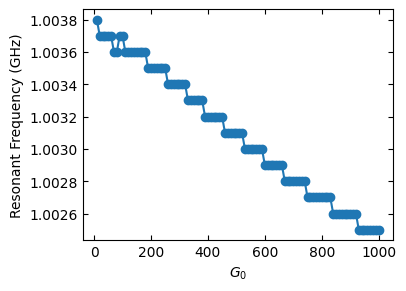

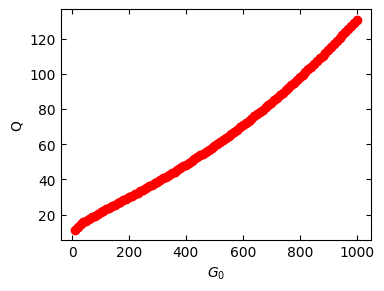

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Sample Data Loading
data = pd.read_csv('/content/g0.txt', sep='\t')

# Initialize lists to store the resonant frequencies and Q values for each L
res_freqs = []
Q_values = []

# Assuming the L values are embedded in the column names
# Extracting L values from the column names and converting them to integers
G0_values = [float(re.search(r'\d+(\.\d+)?', col.split('=')[1]).group()) for col in data.columns[1:]]


# Loop through each column (ignoring the frequency column)
for column in data.columns[1:]:
    # 1. Find the resonant frequency f0: frequency with maximum S21
    f0_index = data[column].idxmax()
    f0 = data['Frequency (GHz)'].iloc[f0_index]
    res_freqs.append(f0)

    # Find points around f1 and f2 for interpolation
    target_S21 = data[column].iloc[f0_index] / np.sqrt(2)
    f1_index = (data[column].iloc[:f0_index] - target_S21).abs().idxmin()
    f2_index = (data[column].iloc[f0_index:] - target_S21).abs().idxmin()
    f1_lower, f1_upper = data['Frequency (GHz)'].iloc[f1_index-1], data['Frequency (GHz)'].iloc[f1_index+1]
    S21_f1_lower, S21_f1_upper = data[column].iloc[f1_index-1], data[column].iloc[f1_index+1]

    f2_lower, f2_upper = data['Frequency (GHz)'].iloc[f2_index-1], data['Frequency (GHz)'].iloc[f2_index+1]
    S21_f2_lower, S21_f2_upper = data[column].iloc[f2_index-1], data[column].iloc[f2_index+1]

    # Linear interpolation to find more precise f1 and f2
    m_f1 = (S21_f1_upper - S21_f1_lower) / (f1_upper - f1_lower)
    c_f1 = S21_f1_lower - m_f1 * f1_lower
    f1_precise = (target_S21 - c_f1) / m_f1

    m_f2 = (S21_f2_upper - S21_f2_lower) / (f2_upper - f2_lower)
    c_f2 = S21_f2_lower - m_f2 * f2_lower
    f2_precise = (target_S21 - c_f2) / m_f2

    # Calculate Q: f0/(f2 - f1)
    Q = f0 / (f2_precise - f1_precise)
    Q_values.append(Q)

# Plot Resonant Frequency vs. L
plt.figure(figsize=(4, 3))
plt.plot(G0_values, res_freqs, marker='o', linestyle='-', label='Resonant Frequency')
plt.xlabel('$G_0$')
plt.ylabel('Resonant Frequency (GHz)')
plt.tick_params(axis='both', which='both', direction='in',  top=True, right=True)
plt.show()

# Plot Q vs. L
plt.figure(figsize=(4, 3))
plt.plot(G0_values, Q_values, marker='o', linestyle='-', label='Q Factor', color='r')
plt.xlabel('$G_0$')
plt.ylabel('Q')
plt.tick_params(axis='both', which='both', direction='in',  top=True, right=True)
plt.show()


In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Load your data as before] ...

# Extract L values using regex
L_values = [float(re.search(r'\d+(\.\d+)?', col.split('=')[1]).group()) for col in data.columns[1:]]

# Find L where resonant frequency crosses 1 GHz
G0_target = None
for i, (L, f_res) in enumerate(zip(L_values, Q_values)):
    # If f_res is 1 GHz, we already have our answer
    if f_res == Q_target:
        G0_target = L
        break

    # If we've gone past 1 GHz and the previous resonant frequency was below 1 GHz
    elif f_res > Q_target and res_freqs[i-1] < Q_target:
        # Linear interpolation
        G0_target = L_values[i-1] + (L_values[i] - L_values[i-1]) * ((1.0 - res_freqs[i-1]) / (f_res - res_freqs[i-1]))
        break

    # If we've gone below 1 GHz and the previous resonant frequency was above 1 GHz
    elif f_res < Q_target and res_freqs[i-1] > Q_target:
        # Linear interpolation
        G0_target = L_values[i-1] + (L_values[i] - L_values[i-1]) * ((1.0 - res_freqs[i-1]) / (f_res - res_freqs[i-1]))
        break

# Print the estimated L value
if G0_target is not None:
    print(f'Estimated G0 for Q={Q_target}: {G0_target}')
else:
    print('No L value found that gives resonant frequency of 1 GHz.')


Estimated G0 for Q=101.17994062351228: 819.9997341434034


## 4.4.2.4 共振器間ギャップの決定

所望の k を達成する共振器間ギャップを決定する。まずギャップを変えながら AWR 上で S21 の周波数特性をシミュレートしテキストファイルに保存する。そこから２つのピークを読み出す。

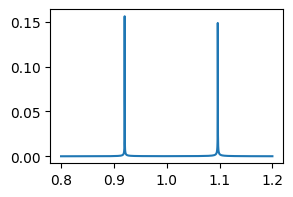

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# Read the data
data = pd.read_csv('/content/k.txt', sep="\t")

# Extract the frequencies
frequencies = data.iloc[:, 0].values
plt.figure(figsize=(3,2))
plt.plot(frequencies,data.iloc[:, 1].values)
plt.show()
peaks_list = []
k_list = []
# Iterate over each column
for col in data.columns[1:]:
    y = data[col].values

    # Detect peaks
    peaks, _ = find_peaks(y, distance=5)  # distance=5 ensures we don't detect multiple peaks too close to each other
    peaks_list.append(frequencies[peaks])
    # Print results
    # print(f"For column {col}: Peaks found at frequencies {frequencies[peaks]}")
    omegaa = np.max(peaks_list[-1])
    omegab = np.min(peaks_list[-1])
    # print(peaks)
    k_list.append((omegaa**2-omegab**2)/(omegaa**2+omegab**2))


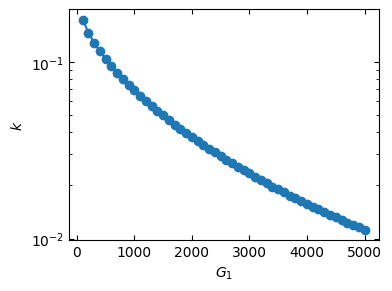

In [ ]:
G_values = [int(re.search(r'(\d+)', col.split('=')[1]).group()) for col in data.columns[1:]]
# Plot Resonant Frequency vs. L
plt.figure(figsize=(4, 3))
plt.plot(G_values, k_list, marker='o', linestyle='-', label='Resonant Frequency')
plt.xlabel('$G_1$')
plt.ylabel('$k$')
plt.yscale("log")
plt.tick_params(axis='both', which='both', direction='in',  top=True, right=True)
plt.show()


In [ ]:
G_values_sorted = np.array(G_values)[np.argsort(k_list)]
k_list_sorted = np.sort(k_list)
print(k_list_sorted)
print(G_values_sorted)
G_target = np.interp(k1, k_list_sorted, G_values_sorted)
print(f"For k={k1} The gap between resonator should be:", G_target)

[0.01124622 0.01164429 0.01194225 0.01234029 0.01273834 0.01323654
 0.0136346  0.01413146 0.01462972 0.01512652 0.01572355 0.01632057
 0.01691758 0.01751458 0.01831057 0.0190061  0.0197035  0.0205979
 0.02149433 0.0223886  0.02338338 0.02437813 0.02557177 0.02666458
 0.02785806 0.02925038 0.03074053 0.03233146 0.03392227 0.03570823
 0.0375949  0.03967994 0.04186593 0.04424592 0.0469253  0.04980247
 0.052872   0.05643868 0.06020189 0.06435316 0.06899973 0.07423653
 0.080157   0.08686117 0.09463742 0.1036766  0.11466354 0.12826348
 0.14640005 0.17339171]
[5000 4900 4800 4700 4600 4500 4400 4300 4200 4100 4000 3900 3800 3700
 3600 3500 3400 3300 3200 3100 3000 2900 2800 2700 2600 2500 2400 2300
 2200 2100 2000 1900 1800 1700 1600 1500 1400 1300 1200 1100 1000  900
  800  700  600  500  400  300  200  100]
For k=0.019942454348982792 The gap between resonator should be: 3373.283513085197
